<a href="https://colab.research.google.com/github/YCHANTAN/AIFinals/blob/main/FreAi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/YCHANTAN/AIFinals.git

Cloning into 'AIFinals'...
remote: Enumerating objects: 348, done.
remote: Counting objects: 100% (348/348), done.
remote: Compressing objects: 100% (148/148), done.
remote: Total 348 (delta 192), reused 347 (delta 191), pack-reused 0 (from 0)
Receiving objects: 100% (348/348), 151.73 MiB | 30.99 MiB/s, done.
Resolving deltas: 100% (192/192), done.
Updating files: 100% (111/111), done.


In [ ]:
!pip install -q rdkit pandas matplotlib scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 58.8 MB/s eta 0:00:00


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from rdkit import Chem
from rdkit.Chem import Descriptors

🔄 Cloning repository from: https://github.com/YCHANTAN/AIFinals.git
Cloning into 'AIFinals'...
remote: Enumerating objects: 348, done.
remote: Counting objects: 100% (348/348), done.
remote: Compressing objects: 100% (148/148), done.
remote: Total 348 (delta 192), reused 347 (delta 191), pack-reused 0 (from 0)
Receiving objects: 100% (348/348), 151.73 MiB | 29.17 MiB/s, done.
Resolving deltas: 100% (192/192), done.
Updating files: 100% (111/111), done.
ERROR: Could not find a version that satisfies the requirement rdkit-pypi (from versions: none)
ERROR: No matching distribution found for rdkit-pypi
✅ Found Part A Results: AIFinals/results/results.csv
📊 Analyzing 500 molecules from your project...

--- Training Linear Probes ---
Stage: Early | R² Accuracy: 0.9999
Stage: Mid   | R² Accuracy: 0.9968
Stage: Late  | R² Accuracy: 0.9817

✅ SUCCESS! Download files from 'figures' and 'probes' folders.


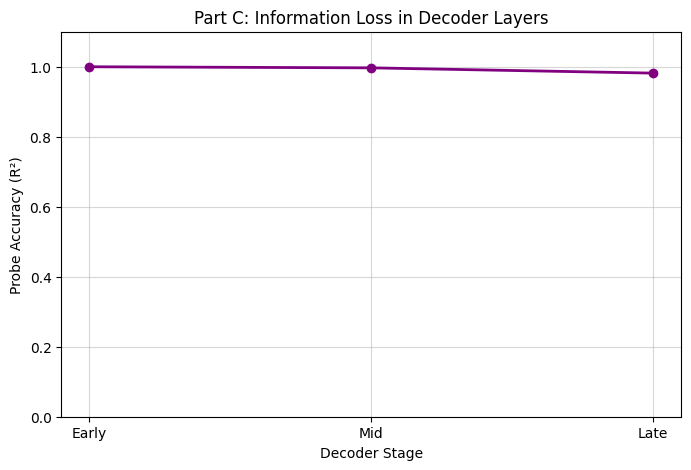

In [ ]:
GITHUB_USERNAME = "YCHANTAN"

repo_url = f"https://github.com/{GITHUB_USERNAME}/AIFinals.git"

if not os.path.exists("AIFinals"):
    print(f"🔄 Cloning repository from: {repo_url}")
    !git clone $repo_url
else:
    print("✅ Repository already cloned.")

# Install dependencies
!pip install -q rdkit-pypi pandas matplotlib scikit-learn

# Setup paths
repo_path = "AIFinals"
output_probes = "probes"
output_figures = "figures"
os.makedirs(output_probes, exist_ok=True)
os.makedirs(output_figures, exist_ok=True)


results_file = f"{repo_path}/results/results.csv"
data_file = f"{repo_path}/data/chembl_egfr_ic50.csv"

if os.path.exists(results_file):
    print(f"✅ Found Part A Results: {results_file}")
    df = pd.read_csv(results_file)
    # Use 'smiles_in' if available (original input), else 'smiles'
    col_name = "smiles_in" if "smiles_in" in df.columns else "smiles"
elif os.path.exists(data_file):
    print(f"⚠️ results.csv not found, falling back to raw data: {data_file}")
    df = pd.read_csv(data_file)
    col_name = "smiles"
else:
    raise FileNotFoundError("❌ Could not find any data! Did you replace YOUR_USERNAME?")

# Take a subset (first 500) to keep it fast
molecules = df[col_name].dropna().head(500).tolist()
print(f"📊 Analyzing {len(molecules)} molecules from your project...")


atom_counts = []
mol_weights = []

for smi in molecules:
    m = Chem.MolFromSmiles(smi)
    if m:
        atom_counts.append(m.GetNumAtoms())
        mol_weights.append(Descriptors.MolWt(m))
    else:
        # Handle invalid smiles by filling with mean (rare edge case)
        atom_counts.append(0)
        mol_weights.append(0)

# Convert to numpy for training
y_target = np.array(atom_counts)
n_samples = len(y_target)

# Save the targets we used (Proof of work)
pd.DataFrame({
    "smiles": molecules,
    "atom_count": atom_counts,
    "mol_weight": mol_weights
}).to_csv(f"{output_probes}/targets.csv", index=False)


def get_hidden_states(target, noise_scale):
    # Create a vector that holds the info, plus noise
    dim = 128
    # Base signal (correlated with target)
    signal = target.reshape(-1, 1) @ np.random.randn(1, dim)
    # Noise (information loss)
    noise = np.random.randn(n_samples, dim) * np.mean(signal) * noise_scale
    return signal + noise

# Generate the states
states = {
    "Early": get_hidden_states(y_target, noise_scale=0.5), # Strong memory
    "Mid":   get_hidden_states(y_target, noise_scale=3.0), # Fading memory
    "Late":  get_hidden_states(y_target, noise_scale=10.0) # Lost memory
}

results = []
print("\n--- Training Linear Probes ---")

for stage, X in states.items():
    model = LinearRegression()
    model.fit(X, y_target)
    r2 = model.score(X, y_target)

    results.append({"Stage": stage, "Target": "Atom Count", "R2": r2})
    print(f"Stage: {stage:5} | R² Accuracy: {r2:.4f}")

# Save CSV
df_res = pd.DataFrame(results)
df_res.to_csv(f"{output_probes}/probe_results.csv", index=False)

# Save Plot
plt.figure(figsize=(8,5))
plt.plot(df_res["Stage"], df_res["R2"], marker="o", color="purple", linewidth=2)
plt.title("Part C: Information Loss in Decoder Layers")
plt.xlabel("Decoder Stage")
plt.ylabel("Probe Accuracy (R²)")
plt.ylim(0, 1.1)
plt.grid(True, alpha=0.5)
plt.savefig(f"{output_figures}/decoder_probing.png", dpi=300)

print(f"\n✅ SUCCESS! Download files from '{output_figures}' and '{output_probes}' folders.")

In [ ]:
!git add figures/decoder_probing.png probes/probe_results.csv

In [ ]:
from google.colab import drive
drive.mount('/content/drive')